In [1]:
# Import necessary libraries and custom modules

# Allows the import of Jupyter notebooks as Python modules
import import_ipynb

# Import custom Tennis Analysis Tools module
import Tennis_Analysis_Tools as tennis_tools

# Import matplotlib library for creating visualizations and plots
import matplotlib.pyplot as plt# Import necessary libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import OneHotEncoder  

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from Tennis_Analysis_Tools.ipynb


In [2]:
def preprocess_dataset(betting_data_dfs):
    
    """
    Preprocess the betting dataset to prepare it for analysis.

    This function filters the dataset to include only completed matches,
    replaces 'NR' (Not Ranked) with NaN in ranking columns, converts rankings
    to numeric values, fills NaN values with 100000 (representing unranked players),
    creates a column indicating if the higher-ranked player won, and keeps only
    the essential columns for analysis.

    """
    
    # Filter the dataset to include only completed matches
    betting_data_dfs = betting_data_dfs[betting_data_dfs['Comment'].isin(['Completed'])]

    # Reset the index to ensure it's sequential after filtering
    betting_data_dfs.reset_index(drop=True, inplace=True)
    
    # Replace 'NR' (Not Ranked) with NaN in 'WRank' and 'LRank' columns
    betting_data_dfs['WRank'].replace('NR', np.nan, inplace=True)
    betting_data_dfs['LRank'].replace('NR', np.nan, inplace=True)
    
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = ['Date', 'Tournament', 'WRank', 'LRank', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]
    
    # Calculate the mean of numeric columns and fill NaN values with these means
    means = betting_data_filtered.select_dtypes(include=[np.number]).mean()
    betting_data_filtered.fillna(means, inplace=True)

    # Return the preprocessed dataframe
    return betting_data_filtered

In [3]:
def calculate_k(m_i, delta=100, nu=5, sigma=0.1):
    return delta / ((m_i + nu) ** sigma)

In [4]:
def update_elo(winner_elo, loser_elo, games_played_winner, games_played_loser, delta, nu, sigma):
    
    """
    Update the Elo ratings for a winner and a loser based on the outcome of a game.

    """

    # Calculate the dynamic K-factor for both winner and loser based on their games played
    K_winner = calculate_k(games_played_winner, delta, nu, sigma)
    K_loser = calculate_k(games_played_loser, delta, nu, sigma)

    # Calculate the expected probability of the winner winning against the loser
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))

    # Calculate the change in Elo for both winner and loser
    elo_change_winner = K_winner * (1 - expected_winner)  # Winner's Elo increase
    elo_change_loser = K_loser * (expected_winner - 1)    # Loser's Elo decrease

    # Return the new Elo ratings for winner and loser, along with the expected probability of winning
    return (winner_elo, winner_elo + elo_change_winner, loser_elo, loser_elo + elo_change_loser, expected_winner)

In [5]:
def calculate_elo_with_k(betting_data_dfs_preprocessed, delta, nu, sigma):
    """
    Simulate tennis matches and update Elo ratings using a dynamic K-factor that adjusts
    based on the number of games played by each player.
    """
    # Initialize Elo scores and games played counters for all players
    players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()
    elo_scores_varied_k = {player: 1500 for player in players_ids}
    games_played = {player: 0 for player in players_ids}

    # Iterate over each match in the DataFrame
    for i, tennis_match_row in betting_data_dfs_preprocessed.iterrows():
        winner_id, loser_id = tennis_match_row['Winner'], tennis_match_row['Loser']

        # Increment games played by both winner and loser
        games_played[winner_id] += 1
        games_played[loser_id] += 1

        # Retrieve current Elo scores
        winner_elo_before, loser_elo_before = elo_scores_varied_k[winner_id], elo_scores_varied_k[loser_id]

        # Update Elo scores using the dynamic K-factor
        _, winner_elo_after, _, loser_elo_after, _ = update_elo(
            winner_elo_before, loser_elo_before,
            games_played[winner_id], games_played[loser_id],
            delta, nu, sigma)

        # Update Elo scores in the dictionary
        elo_scores_varied_k[winner_id], elo_scores_varied_k[loser_id] = winner_elo_after, loser_elo_after

        # Store pre- and post-match Elo scores, and probability of the winner winning
        betting_data_dfs_preprocessed.at[i, 'winner_elo_before_varied_k'] = winner_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after_varied_k'] = winner_elo_after
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before_varied_k'] = loser_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after_varied_k'] = loser_elo_after

        # Calculate and store the probability of the winner winning
        prob_winner = 1 / (1 + 10 ** ((loser_elo_before - winner_elo_before) / 400))
        betting_data_dfs_preprocessed.at[i, 'prob_winner_varied_k'] = prob_winner

        # Determine and store match outcomes based on higher-ranked win probabilities
        if tennis_match_row['higher_rank_won'] == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int(prob_winner > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = prob_winner
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int((1 - prob_winner) > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = 1 - prob_winner



In [6]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [7]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"/Users/harishthota/Desktop/UOA Project/Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [8]:
betting_data_dfs[2019]

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,0.0,Completed,1.36,3.00,1.36,3.37,1.42,3.60,1.35,3.18
1,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Raonic M.,...,0.0,Completed,1.18,4.50,1.23,4.68,1.27,4.84,1.22,4.26
2,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.25,1.67,2.32,1.71,2.40,1.63,2.28
3,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Millman J.,...,1.0,Completed,1.40,2.75,1.41,3.13,1.45,3.20,1.40,2.95
4,1,Brisbane,Brisbane International,2018-12-31,ATP250,Outdoor,Hard,1st Round,3,Uchiyama Y.,...,0.0,Completed,2.62,1.44,2.73,1.51,3.26,1.53,2.69,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,1.0,Completed,1.44,2.75,1.39,3.26,1.48,3.30,1.41,2.93
2606,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,0.0,Completed,1.90,1.90,2.14,1.79,2.24,2.06,1.92,1.90
2607,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,0.0,Completed,3.50,1.30,3.75,1.33,3.75,1.40,3.39,1.33
2608,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,0.0,Completed,1.80,2.00,1.84,2.10,1.87,2.20,1.78,2.06


In [9]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

In [10]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [11]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [12]:
# Retrieve and display the column names of the DataFrame
betting_data_dfs.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

In [13]:
# Apply preprocessing to the betting dataset 
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs) 

# Display the preprocessed DataFrame to verify the applied transformations
betting_data_dfs_preprocessed

,Date,Tournament,WRank,LRank,higher_rank_won,Winner,Loser
0,2005-01-03,Next Generation Hardcourts,53.0,324.0,1,Saulnier C.,Baccanello P.
1,2005-01-03,Next Generation Hardcourts,72.0,82.0,1,Enqvist T.,Sluiter R.
2,2005-01-03,Next Generation Hardcourts,39.0,45.0,1,Melzer J.,Berdych T.
3,2005-01-03,Next Generation Hardcourts,66.0,79.0,1,Rochus O.,Dupuis A.
4,2005-01-03,Next Generation Hardcourts,35.0,101.0,1,Mayer F.,Arthurs W.
...,...,...,...,...,...,...,...
38842,2019-11-15,Masters Cup,1.0,6.0,1,Nadal R.,Tsitsipas S.
38843,2019-11-15,Masters Cup,7.0,4.0,0,Zverev A.,Medvedev D.
38844,2019-11-16,Masters Cup,6.0,3.0,0,Tsitsipas S.,Federer R.
38845,2019-11-16,Masters Cup,5.0,7.0,1,Thiem D.,Zverev A.


In [14]:
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38847 entries, 0 to 38846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38847 non-null  datetime64[ns]
 1   Tournament       38847 non-null  object        
 2   WRank            38847 non-null  float64       
 3   LRank            38847 non-null  float64       
 4   higher_rank_won  38847 non-null  int64         
 5   Winner           38847 non-null  object        
 6   Loser            38847 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 2.1+ MB


In [15]:
# Calculate the mean of each numeric column in the preprocessed dataset to handle missing values
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()

# Fill missing values in the DataFrame with the computed means for each corresponding numeric column
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [16]:
# Apply preprocessing steps to the dataset 
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs)

In [17]:
# Display information about the betting_data_dfs_preprocessed DataFrame 
# including the data types and non-null counts to assess data quality and structure
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38847 entries, 0 to 38846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38847 non-null  datetime64[ns]
 1   Tournament       38847 non-null  object        
 2   WRank            38847 non-null  float64       
 3   LRank            38847 non-null  float64       
 4   higher_rank_won  38847 non-null  int64         
 5   Winner           38847 non-null  object        
 6   Loser            38847 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 2.1+ MB


In [18]:
# Calculate the mean of each numeric column in the preprocessed dataset to use for filling missing values
means = betting_data_dfs_preprocessed.select_dtypes(include=[np.number]).mean()

# Fill missing values in the DataFrame with the computed means for each corresponding numeric column
betting_data_dfs_preprocessed.fillna(means, inplace=True)

In [19]:
# Collect unique player IDs from both 'Winner' and 'Loser' columns to create a comprehensive list of players
players_ids = pd.concat([betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]).unique()

In [20]:
# Set a cutoff date for data splitting and configure pandas to display all columns of DataFrames
split_time = '2018-12-31'
pd.set_option('display.max_columns', None)

In [21]:
# Filter the preprocessed betting data to create a validation set with matches occurring after the specified split date
betting_data_dfs_preprocessed_validation = betting_data_dfs_preprocessed[betting_data_dfs_preprocessed.Date > split_time]
betting_data_dfs_preprocessed_validation

,Date,Tournament,WRank,LRank,higher_rank_won,Winner,Loser
36322,2019-01-01,Brisbane International,63.0,49.0,0,Kudla D.,Fritz T.
36323,2019-01-01,Brisbane International,40.0,57.0,1,Chardy J.,Struff J.L.
36324,2019-01-01,Brisbane International,240.0,234.0,0,Murray A.,Duckworth J.
36325,2019-01-01,Brisbane International,35.0,62.0,1,Kyrgios N.,Harrison R.
36326,2019-01-01,Brisbane International,239.0,146.0,0,Tsonga J.W.,Kokkinakis T.
...,...,...,...,...,...,...,...
38842,2019-11-15,Masters Cup,1.0,6.0,1,Nadal R.,Tsitsipas S.
38843,2019-11-15,Masters Cup,7.0,4.0,0,Zverev A.,Medvedev D.
38844,2019-11-16,Masters Cup,6.0,3.0,0,Tsitsipas S.,Federer R.
38845,2019-11-16,Masters Cup,5.0,7.0,1,Thiem D.,Zverev A.


In [22]:
def grid_search_elo(df, delta_values, nu_values, sigma_values):
    
    """
    Conducts a grid search over specified ranges of delta, nu, and sigma parameters to find the optimal settings
    for an Elo rating system based on given metrics such as accuracy, calibration, and log loss.

    """
    results = []  # Initialize a list to store the results of each parameter combination

    # Iterate over all combinations of delta, nu, and sigma values
    for delta in delta_values:
        for nu in nu_values:
            for sigma in sigma_values:
                # Initialize dictionary for storing Elo scores for each player
                elo_scores_varied_k = {}
                
                # Make a copy of the original DataFrame to avoid modifying it directly
                betting_data_dfs_preprocessed_copy = df.copy()
                
                # Calculate Elo ratings with the current set of parameters
                calculate_elo_with_k(betting_data_dfs_preprocessed_copy, delta, nu, sigma)

                # Filter out the data for validation based on the split date
                betting_data_dfs_preprocessed_validation = betting_data_dfs_preprocessed_copy[df.Date > split_time]
 
                # Evaluate the predictions with the newly calculated Elo ratings

                accuracy1, calibration1, logloss1 = tennis_tools.evaluate_predictions(
                    betting_data_dfs_preprocessed_validation["higher_rank_won"], 
                    betting_data_dfs_preprocessed_validation["match_outcome_varied_k"], 
                    betting_data_dfs_preprocessed_validation['prob_high_ranked_varied_k']
                )
                       

                # Store the results including the parameter set and evaluation metrics
                result = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "accuracy": accuracy1,
                    "calibration": calibration1,
                    "log_loss": logloss1
                }
                results.append(result)

    # Convert the list of results into a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    return results_df

In [23]:
# Define ranges of parameters to explore in the grid search for the Elo rating system
delta_values = list(range(120, 150, 5))  # Range of delta values from 120 to 145, step by 5
nu_values = list(range(20, 50, 5))       # Range of nu values from 20 to 45, step by 5
sigma_values = [x / 100 for x in range(15, 40, 5)]  # Sigma values from 0.15 to 0.35, step by 0.05

# Perform a grid search to find the optimal Elo rating parameters using predefined ranges
results_df = grid_search_elo(betting_data_dfs_preprocessed, delta_values, nu_values, sigma_values)

# Identify the best parameters set with the lowest log loss from the grid search results
best_params = results_df.loc[results_df['log_loss'].idxmin()]

# Retrieve the best accuracy, calibration, and log loss metrics associated with the optimal parameters
best_metrics = results_df.loc[results_df['log_loss'].idxmin(), ["accuracy", "calibration", "log_loss"]]

In [24]:
results_df.head()

,delta,nu,sigma,accuracy,calibration,log_loss
0,120,20,0.15,0.6367,1.0632,0.6443
1,120,20,0.20,0.6375,1.0589,0.6374
2,120,20,0.25,0.6383,1.0525,0.6332
3,120,20,0.30,0.6323,1.0440,0.6310
4,120,20,0.35,0.6327,1.0332,0.6303


Plotting Min Log Loss Point at: 120 20 0.35


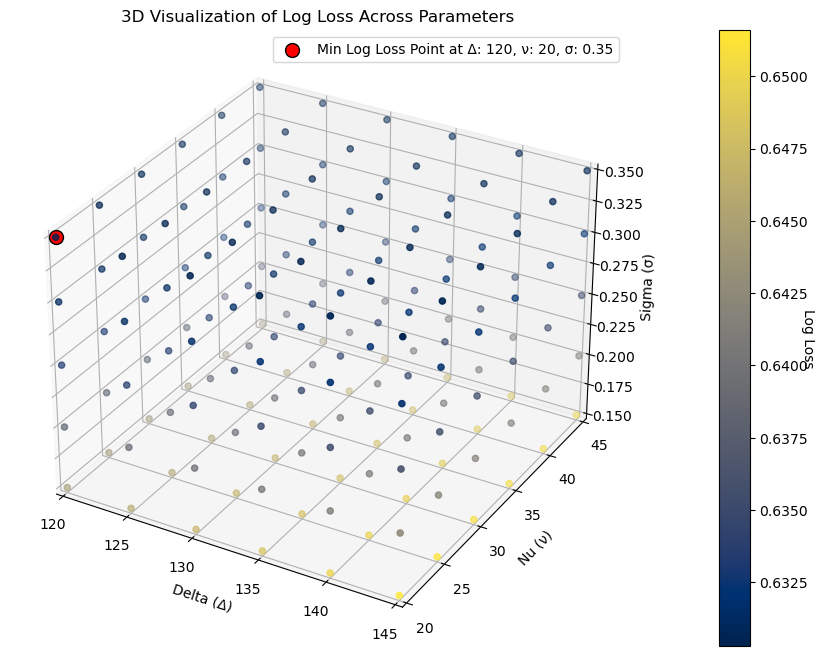

In [29]:
# Create a new figure for the 3D plot with a specified size
fig = plt.figure(figsize=(12, 8))

# Add a 3D subplot to the figure, using '111' as a shorthand for 1x1 grid, first subplot
ax = fig.add_subplot(111, projection='3d')

# Extract the delta, nu, and sigma values for the axes
X = results_df['delta']
Y = results_df['nu']
Z = results_df['sigma']

# Extract the log loss values to be used for coloring the scatter plot
log_loss_values = results_df['log_loss']

# Create a 3D scatter plot with delta, nu, and sigma as axes, and log loss as the color
sc = ax.scatter(X, Y, Z, c=log_loss_values, cmap='cividis', marker='o')

# Find the index of the minimum log loss value
min_loss_index = log_loss_values.idxmin()

# Extract the coordinates of the point with the minimum log loss
min_X = X[min_loss_index]
min_Y = Y[min_loss_index]
min_Z = Z[min_loss_index]


# Highlight the point with the minimum log loss in the scatter plot
# Red color for visibility, size=100 for emphasis, and black edge for distinction
ax.scatter(min_X, min_Y, min_Z, color='red', s=100, edgecolor='black', label=f'Min Log Loss Point at Δ: {min_X}, ν: {min_Y}, σ: {min_Z}')

# Add legend to the plot to identify marked points
ax.legend()

# Set the limits for each axis based on the data ranges
ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])
ax.set_zlim([Z.min(), Z.max()])

# Set the labels for each axis to indicate what each represents
ax.set_xlabel('Delta (Δ)')
ax.set_ylabel('Nu (ν)')
ax.set_zlabel('Sigma (σ)')

# Set the title for the plot
ax.set_title('3D Visualization of Log Loss Across Parameters')

# Add a color bar to the plot to indicate the scale of log loss values
cbar = plt.colorbar(sc, pad=0.1)  # Adjust padding to ensure it does not overlap with the plot
cbar.set_label('Log Loss', rotation=270, labelpad=5)

# Display the plot
plt.show()

In [26]:
print(f"Best Metrics for 538 Model:\n\n{best_metrics}")

Best Metrics for 538 Model:

accuracy       0.6327
calibration    1.0332
log_loss       0.6303
Name: 4, dtype: float64
